In [2]:
import numpy as np
import seaborn as sns
import metrics_utils
import load_utils
from pathlib import Path
import significantdigits as sd
from matplotlib import pyplot as plt
from fsl.transform import affine

import warnings
warnings.filterwarnings('ignore')

In [2]:
#remove all the numbers later 50, 10, 3 etc
import importlib
importlib.reload(metrics_utils)

<module 'metrics_utils' from '/lustre06/project/6061841/niusham/mca_linear_registration/metrics_utils.py'>

In [5]:
# path_PD = './outputs_PD/anat-12dofs'
# path_HC = './outputs_HC/anat-12dofs'

path_PD = Path('./pipline/pd/outputs/anat-12dofs')
path_HC = Path('./pipline/hc/outputs/anat-12dofs')

In [6]:
paths_PD = load_utils.get_paths(path_PD, Path("./PD_selected_subjects.txt"), pattern="_ses-BL")
paths_HC = load_utils.get_paths(path_HC, Path("./HC_selected_subjects.txt"), pattern="_ses-BL")

In [7]:
mat_dic_PD, error_PD = load_utils.get_matrices(paths_PD)
mat_dic_HC, error_HC = load_utils.get_matrices(paths_HC)

In [8]:
error_PD, error_HC

([], [])

In [ ]:
#removing failed subject from fsl 
# failed_hc_subs = ["sub-116230", "sub-4079", "sub-3620"]
# failed_pd_subs = ["sub-3709", "sub-3700", "sub-3403"]

# for sub in failed_hc_subs:
#     del mat_dic_HC[sub]

# for sub in failed_pd_subs:
#     del mat_dic_PD[sub]

: 

In [ ]:
# all_failed_hc_subs = ["sub-116230", "sub-3620","sub-4079"]
# all_failed_pd_subs = ["sub-3365", "sub-3709", "sub-3700", "sub-3403"]

# for sub in all_failed_hc_subs:
#     del mat_dic_HC[sub]

# for sub in all_failed_pd_subs:
#     del mat_dic_PD[sub]
 

: 

In [9]:
n_pd_fsl = len(mat_dic_PD.keys())
n_hc_fsl = len(mat_dic_HC.keys())

In [10]:
mean_PD, std_PD = np.zeros((n_pd_fsl,4,4)), np.zeros((n_pd_fsl,4,4))
mean_HC, std_HC = np.zeros((n_hc_fsl,4,4)), np.zeros((n_hc_fsl,4,4))

for i,sub in enumerate(mat_dic_PD.keys()):
    mean_PD[i] = np.mean(mat_dic_PD[sub]["mca"], axis=0)
    std_PD[i] = np.std(mat_dic_PD[sub]["mca"], axis=0)

for i,sub in enumerate(mat_dic_HC.keys()):
    mean_HC[i] = np.mean(mat_dic_HC[sub]['mca'], axis=0)
    std_HC[i] = np.std(mat_dic_HC[sub]["mca"], axis=0)


In [11]:
def cell_significant_digit(mat_dic):

    significant_digits_dict = {key:np.zeros((4,4)) for key in mat_dic.keys()}
    for key in mat_dic.keys():
        matrix = mat_dic[key]['mca']
        mean_sub = np.mean(matrix, axis=0)
        for i in range(4):
            for j in range(4):
                significant_digits_dict[key][i,j] = sd.significant_digits(matrix[:,i,j], reference=mean_sub[i,j], basis=10)
    
    return significant_digits_dict

In [12]:
cell_significant_digits_dict_PD = cell_significant_digit(mat_dic_PD)
cell_significant_digits_dict_HC = cell_significant_digit(mat_dic_HC)

In [13]:
cell_significant_digits_PD = np.array(list(cell_significant_digits_dict_PD.values()))
cell_significant_digits_HC = np.array(list(cell_significant_digits_dict_HC.values()))

Text(0.5, 1.0, 'MCA means for each cell _PD subjects_')

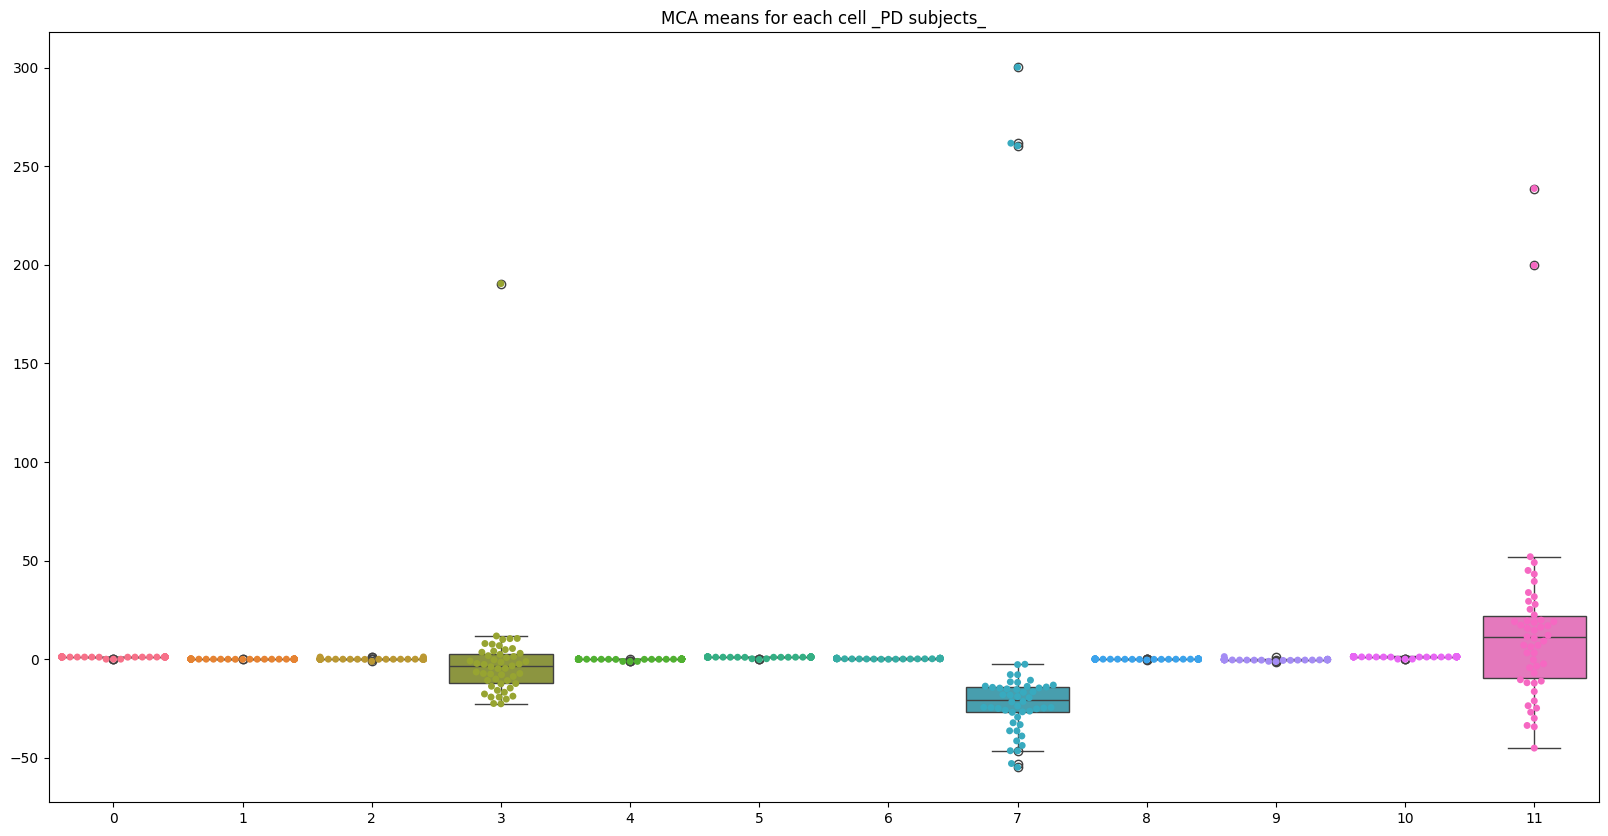

In [14]:
plt.figure(figsize=(20,10))
_ = sns.swarmplot(mean_PD[:,:3,:].reshape(-1,12))
_ = sns.boxplot(mean_PD[:,:3,:].reshape(-1,12))
plt.title('MCA means for each cell _PD subjects_')

Text(0.5, 1.0, 'MCA SD for each cell _PD subjects_')

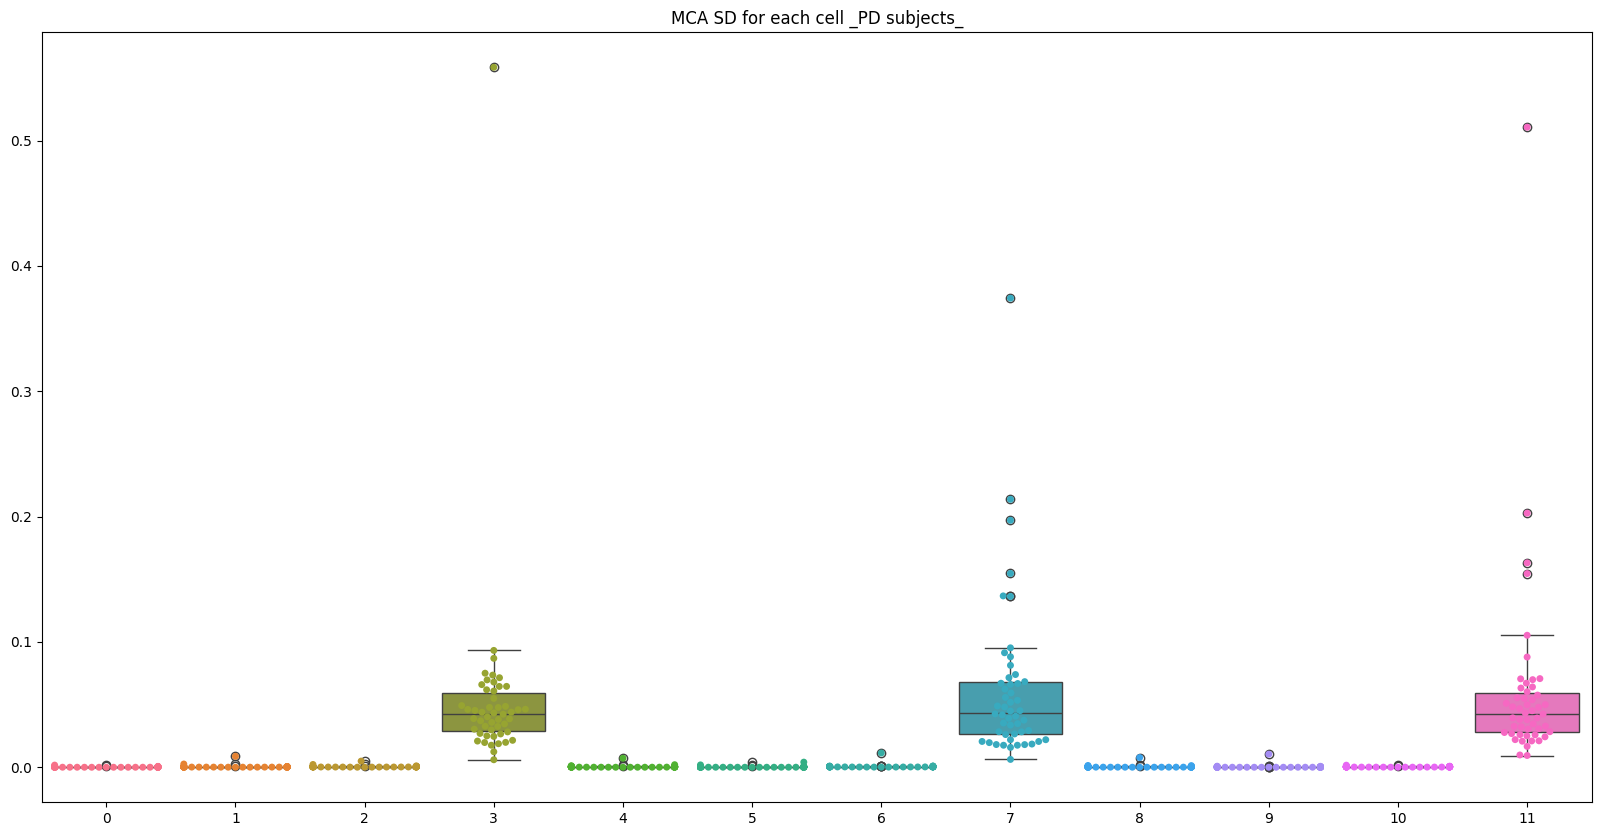

In [15]:
plt.figure(figsize=(20,10))
_ = sns.swarmplot(std_PD[:,:3,:].reshape(-1,12))
_ = sns.boxplot(std_PD[:,:3,:].reshape(-1,12))
plt.title('MCA SD for each cell _PD subjects_')

Text(0.5, 1.0, 'MCA means for each cell _HC subjects_')

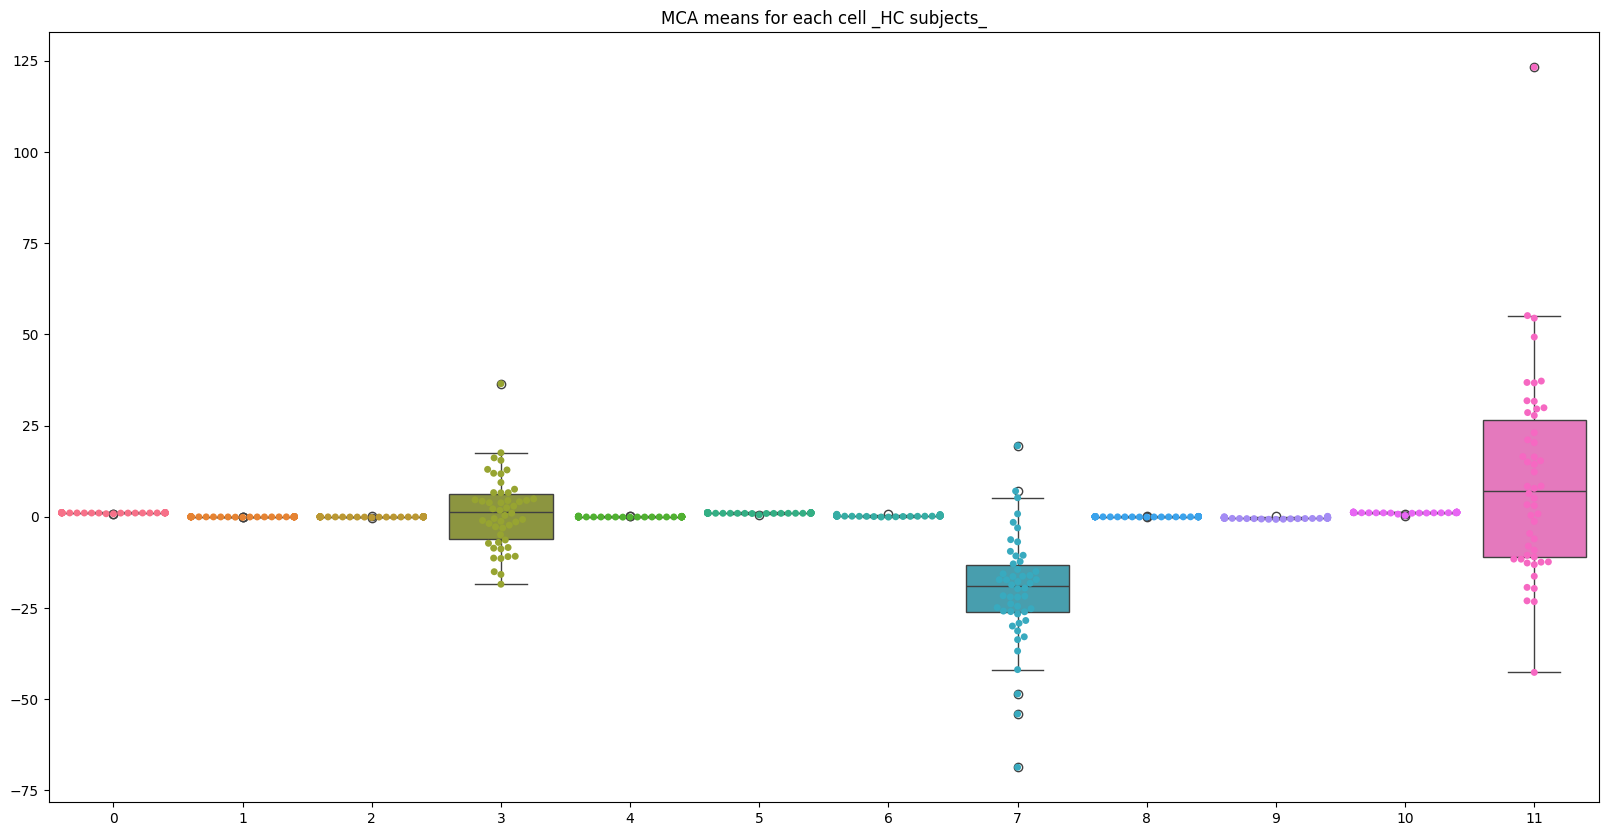

In [16]:
plt.figure(figsize=(20,10))
sns.swarmplot(mean_HC[:,:3,:].reshape(-1,12))
sns.boxplot(mean_HC[:,:3,:].reshape(-1,12))
plt.title('MCA means for each cell _HC subjects_')

Text(0.5, 1.0, 'MCA sds for each cell _HC subjects_')

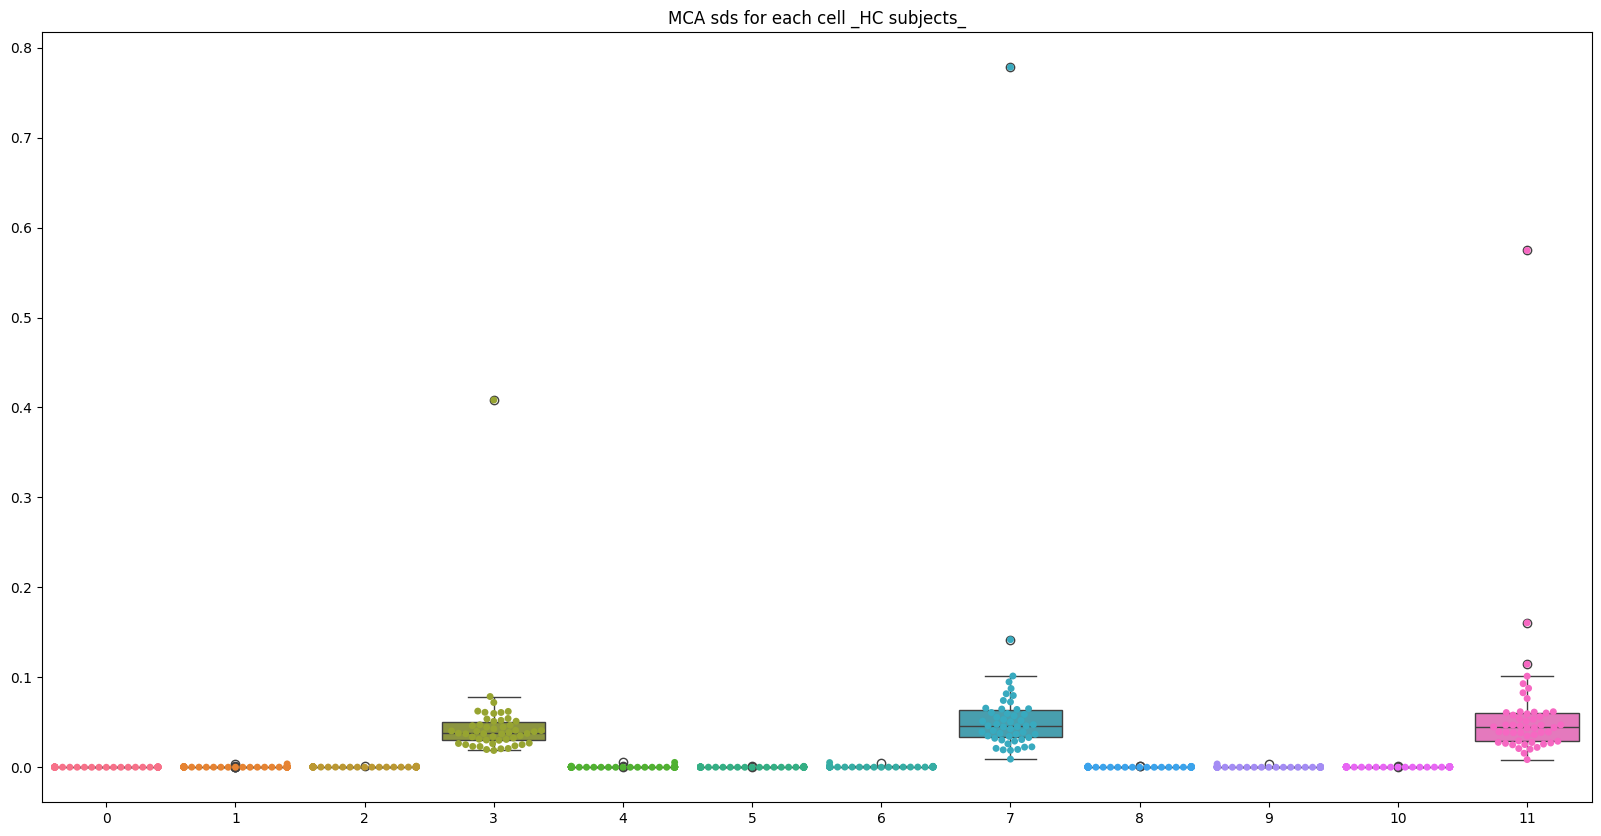

In [17]:
plt.figure(figsize=(20,10))
sns.swarmplot(std_HC[:,:3,:].reshape(-1,12))
sns.boxplot(std_HC[:,:3,:].reshape(-1,12))
plt.title('MCA sds for each cell _HC subjects_')

Text(0.5, 1.0, 'Significant digits for each cell _PD subjects_')

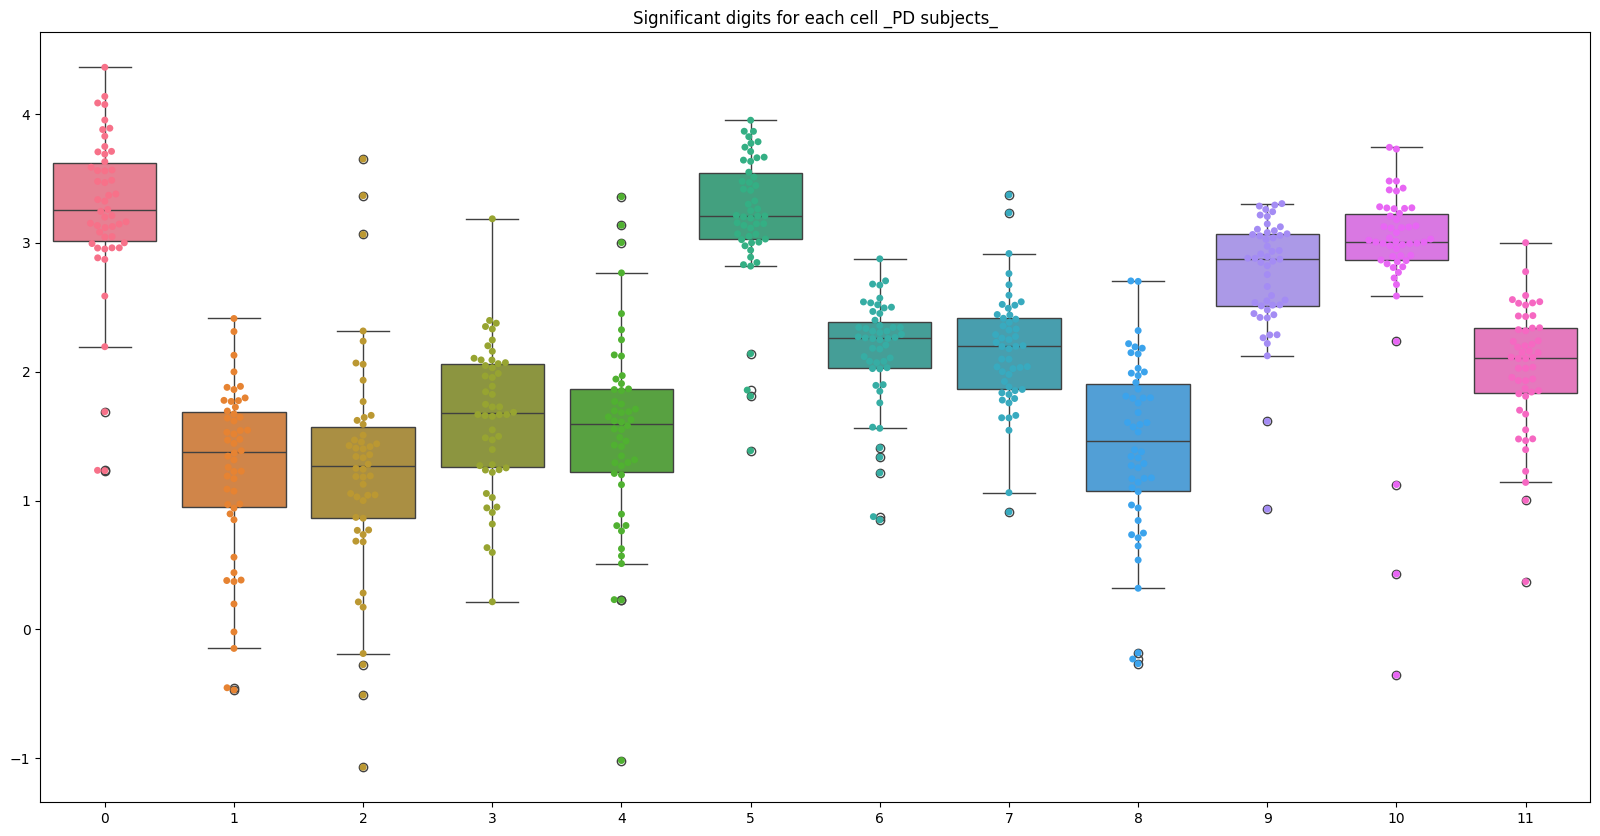

In [18]:
plt.figure(figsize=(20,10))
sns.swarmplot(cell_significant_digits_PD[:,:3,:].reshape(-1,12))
sns.boxplot(cell_significant_digits_PD[:,:3,:].reshape(-1,12))
plt.title('Significant digits for each cell _PD subjects_')

Text(0.5, 1.0, 'Significant digits for each cell _HC subjects_')

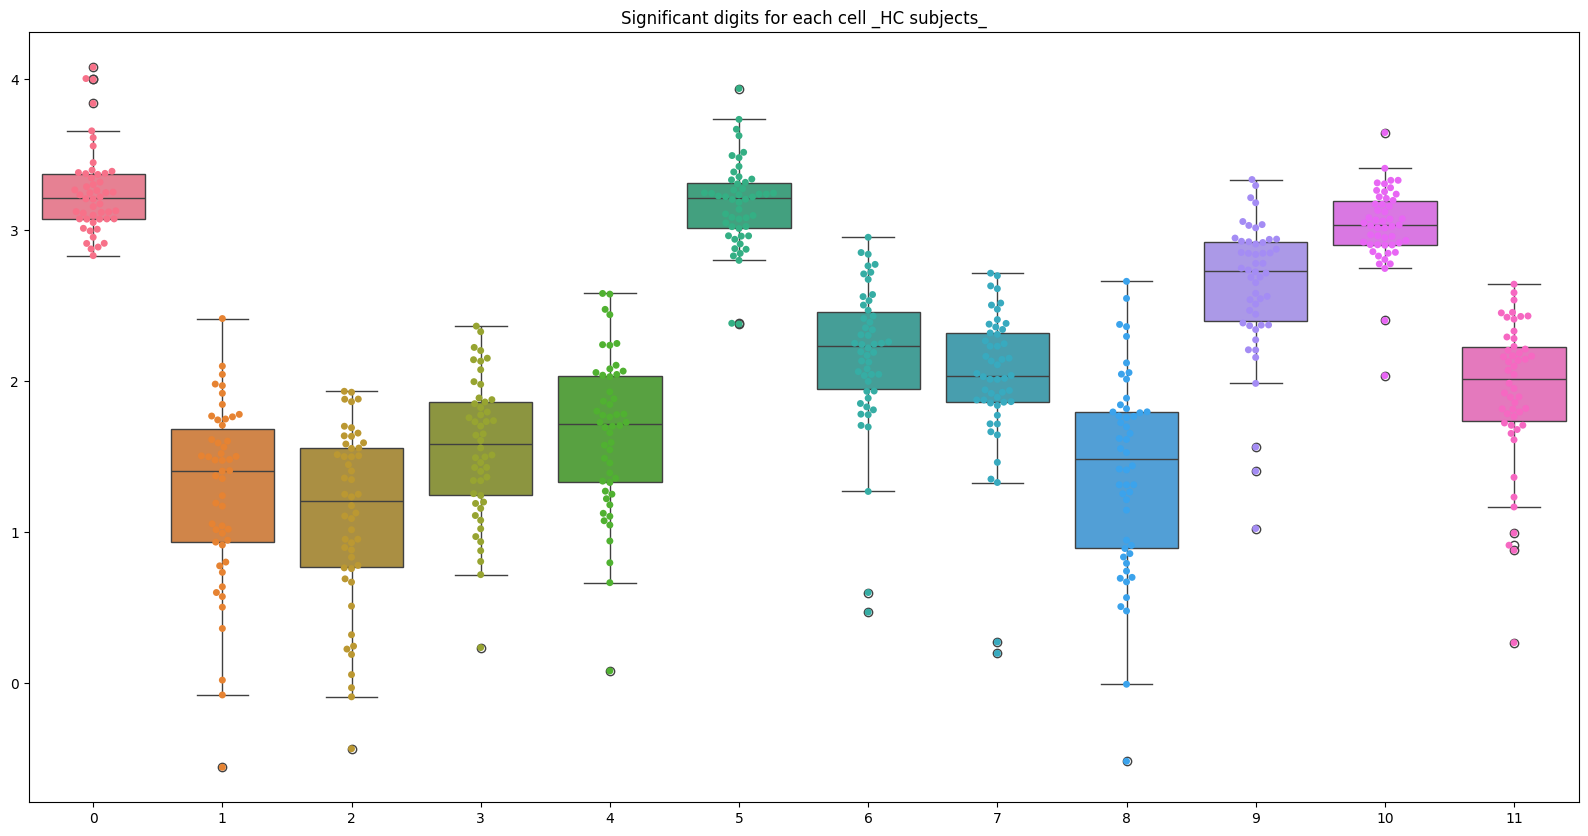

In [19]:
plt.figure(figsize=(20,10))
sns.swarmplot(cell_significant_digits_HC[:,:3,:].reshape(-1,12))
sns.boxplot(cell_significant_digits_HC[:,:3,:].reshape(-1,12))
plt.title('Significant digits for each cell _HC subjects_')

In [20]:
def transformation_dictionaries_mca(mat_dic, n_mca=10):

    scales_mca_dict = {sub:np.zeros((n_mca, 3)) for sub in mat_dic.keys()}
    translation_mca_dict = {sub:np.zeros((n_mca, 3)) for sub in mat_dic.keys()}
    angles_mca_dict = {sub:np.zeros((n_mca, 3)) for sub in mat_dic.keys()}
    shears_mca_dict = {sub:np.zeros((n_mca, 3)) for sub in mat_dic.keys()}

    for sub in mat_dic.keys():
        for (i,matrix) in enumerate(mat_dic[sub]['mca']):
            scales, translations, angles, shears = affine.decompose(matrix, shears=True, angles=True)
            scales_mca_dict[sub][i] = scales
            translation_mca_dict[sub][i] = translations
            # angles_mca_dict[sub][i] = np.mod(np.array(angles), 2 * np.pi)
            angles_mca_dict[sub][i] = np.array(angles)
            shears_mca_dict[sub][i] = shears
    return scales_mca_dict, translation_mca_dict, angles_mca_dict, shears_mca_dict

In [21]:
def transformation_arrays_ieee(mat_dic):
    n = len(mat_dic.keys())
    scales_ieee = np.zeros((n, 3))
    translations_ieee = np.zeros((n, 3))
    angles_ieee = np.zeros((n, 3))
    shears_ieee = np.zeros((n, 3))

    for i, sub in enumerate(mat_dic.keys()):
        scales_ieee[i], translations_ieee[i], angles_ieee[i], shears_ieee[i] = affine.decompose(mat_dic[sub]['ieee'], shears=True, angles=True)
    # np.mod(np.array(angles_ieee), 2 * np.pi)
    return scales_ieee, translations_ieee, angles_ieee, shears_ieee
    

In [22]:
# # Define the positions for the boxplots
# positions_pd = [1]  # Positions for PD
# positions_hc = [2]  # Positions for HC


# def plotter(data_PD, data_HC, title):
#     """
#     Plots data for PD and HC.

#     Parameters:
#     data_PD (numpy.ndarray): The PD data.
#     data_HC (numpy.ndarray): The HC data.
#     title (str): The title of the plot.
#     """
#     dims = data_PD.shape[-1]
#     num_columns = 3

#     for i in range(dims):
#         plt.subplot(1, num_columns, i+1)
        
#         data = np.column_stack([data_PD[:,i], data_HC[:,i]])

#         sns.swarmplot(data)
#         sns.boxplot(data, color='white')

#         plt.xticks([0,1], ['PD axis ' + str(i+1), 'HC axis '+ str(i+1)])
#         if i == 1 or (i == 0 and dims == 1):
#             plt.title(title)

#     plt.show()

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plotter(data_PD, data_HC, title):
    """
    Plots data for PD and HC.

    Parameters:
    data_PD (numpy.ndarray): The PD data.
    data_HC (numpy.ndarray): The HC data.
    title (str): The title of the plot.
    """
    dims = data_PD.shape[-1]
    num_columns = 3

    for i in range(dims):
        plt.subplot(1, num_columns, i+1)
        
        # Create a DataFrame for each dataset
        df_PD = pd.DataFrame({
            'Group': 'PD',
            'Value': data_PD[:,i]
        })

        df_HC = pd.DataFrame({
            'Group': 'HC',
            'Value': data_HC[:,i]
        })

        # Concatenate the DataFrames
        df = pd.concat([df_PD, df_HC])

        # Create the swarmplot
        sns.swarmplot(x='Group', y='Value', data=df, palette=['orange', 'blue'])
        sns.boxplot(x='Group', y='Value', data=df, color='white')
        if i == 1 or (i == 0 and dims == 1):
            plt.title(title)

    plt.show()

In [24]:
scales_ieee_PD, translations_ieee_PD, angles_ieee_PD, shears_ieee_PD = transformation_arrays_ieee(mat_dic_PD)
scales_ieee_HC, translations_ieee_HC, angles_ieee_HC, shears_ieee_HC = transformation_arrays_ieee(mat_dic_HC)

scales_mca_dict_PD, translation_mca_dict_PD, angles_mca_dict_PD, shears_mca_dict_PD = transformation_dictionaries_mca(mat_dic_PD)
scales_mca_dict_HC, translation_mca_dict_HC, angles_mca_dict_HC, shears_mca_dict_HC = transformation_dictionaries_mca(mat_dic_HC)

In [25]:
scales_mca_PD = np.stack([value for value in scales_mca_dict_PD.values()])
scales_mca_HC = np.stack([value for value in scales_mca_dict_HC.values()])

In [26]:
scales_significant_PD = np.stack([sd.significant_digits(scales_mca_PD[i,:,:], reference=np.mean(scales_mca_PD[i,:,:]), axis=0) for i in range(n_pd_fsl)])
scales_significant_HC = np.stack([sd.significant_digits(scales_mca_HC[i,:,:], reference=np.mean(scales_mca_HC[i,:,:]), axis=0) for i in range(n_hc_fsl)])

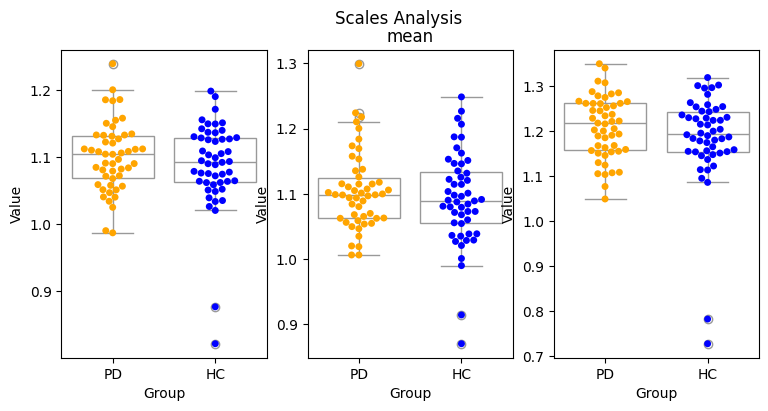

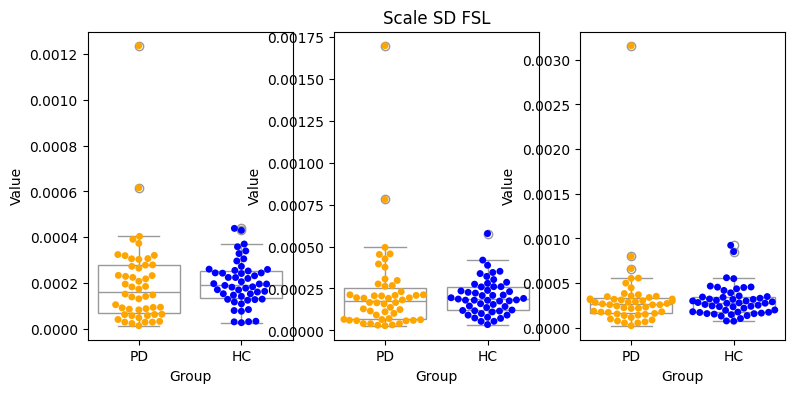

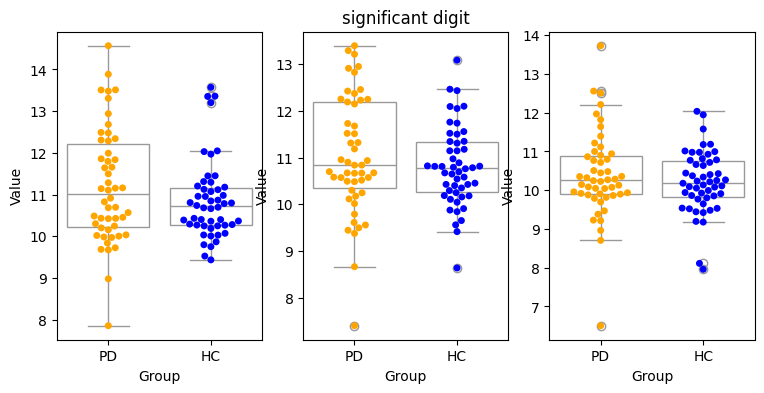

In [27]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle('Scales Analysis')
plotter(np.mean(scales_mca_PD, axis=1),np.mean(scales_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(scales_mca_PD, axis=1),np.std(scales_mca_HC, axis=1), 'Scale SD FSL')


fig = plt.figure(figsize=(9, 4))
plotter(scales_significant_PD,scales_significant_HC, 'significant digit')



In [28]:
translations_mca_PD = np.stack([value for value in translation_mca_dict_PD.values()])
translations_mca_HC = np.stack([value for value in translation_mca_dict_HC.values()])

In [29]:
translations_significant_PD = np.stack([sd.significant_digits(translations_mca_PD[i,:,:], reference=np.mean(translations_mca_PD[i,:,:]), axis=0) for i in range(n_pd_fsl)])
translations_significant_HC = np.stack([sd.significant_digits(translations_mca_HC[i,:,:], reference=np.mean(translations_mca_HC[i,:,:]), axis=0) for i in range(n_hc_fsl)])

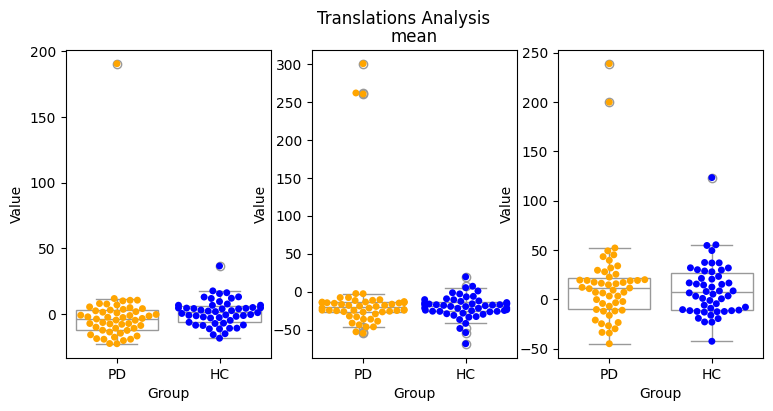

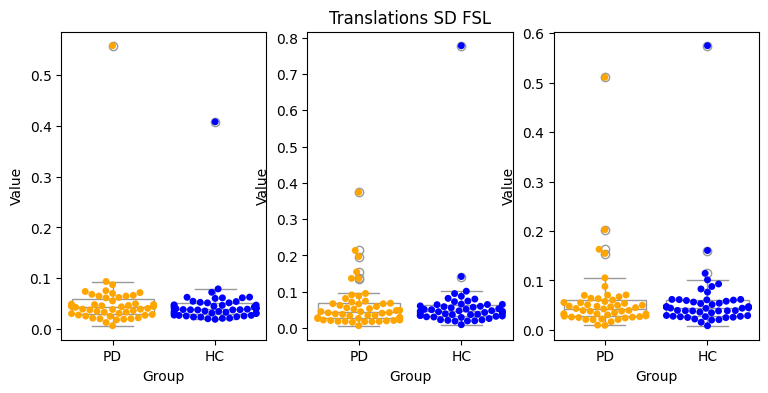

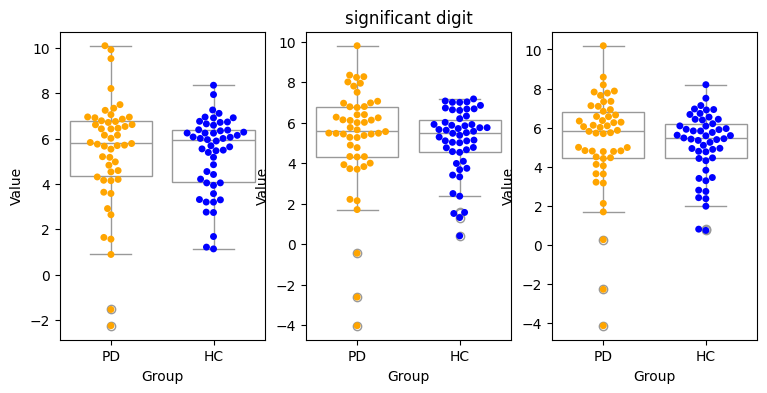

In [30]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle('Translations Analysis')
plotter(np.mean(translations_mca_PD, axis=1),np.mean(translations_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(translations_mca_PD, axis=1),np.std(translations_mca_HC, axis=1), 'Translations SD FSL')


fig = plt.figure(figsize=(9, 4))
plotter(translations_significant_PD,translations_significant_HC, 'significant digit')



In [31]:
shears_mca_PD = np.stack([value for value in shears_mca_dict_PD.values()])
shears_mca_HC = np.stack([value for value in shears_mca_dict_HC.values()])

In [32]:
shears_significant_PD = np.stack([sd.significant_digits(shears_mca_PD[i,:,:], reference=np.mean(shears_mca_PD[i,:,:]), axis=0) for i in range(n_pd_fsl)])
shears_significant_HC = np.stack([sd.significant_digits(shears_mca_HC[i,:,:], reference=np.mean(shears_mca_HC[i,:,:]), axis=0) for i in range(n_hc_fsl)])

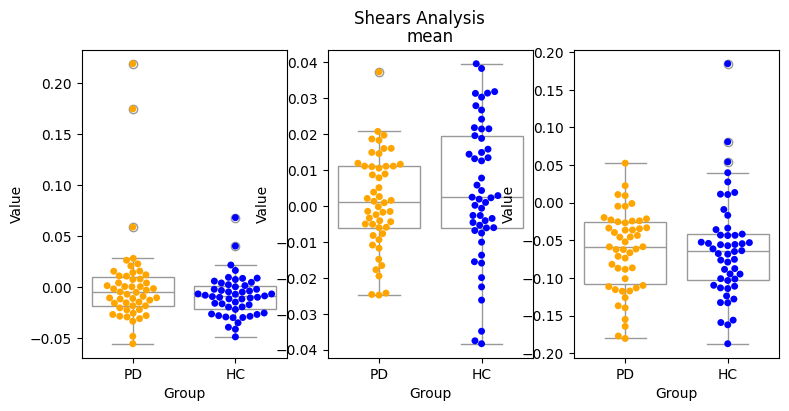

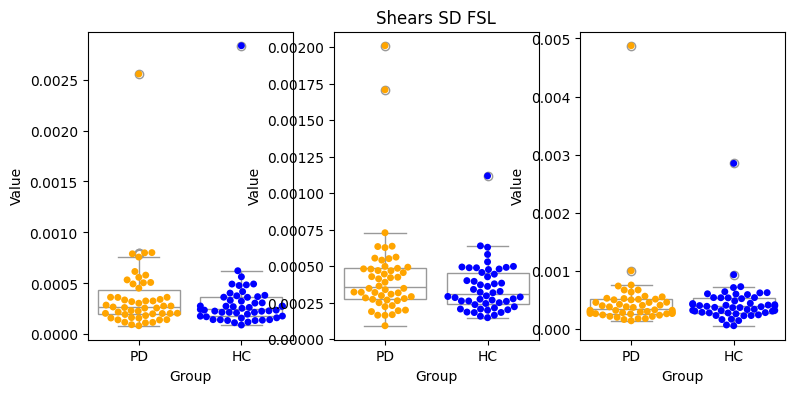

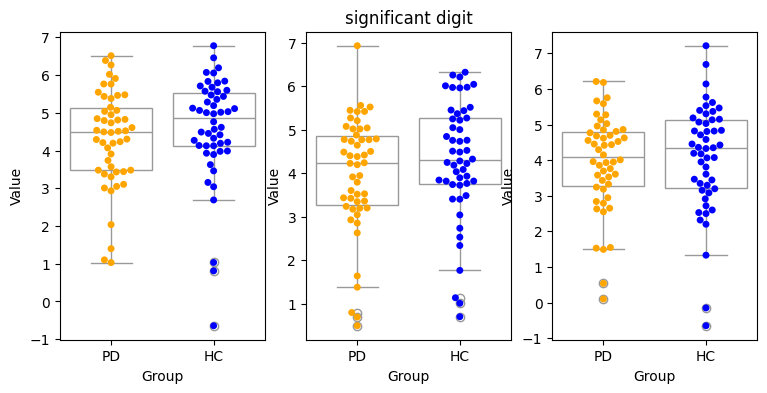

In [33]:

fig = plt.figure(figsize=(9, 4))
fig.suptitle('Shears Analysis')
plotter(np.mean(shears_mca_PD, axis=1),np.mean(shears_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(shears_mca_PD, axis=1),np.std(shears_mca_HC, axis=1), 'Shears SD FSL')


fig = plt.figure(figsize=(9, 4))
plotter(shears_significant_PD,shears_significant_HC, 'significant digit')


In [34]:
angles_mca_PD = np.degrees(np.stack([value for value in angles_mca_dict_PD.values()]))
angles_mca_HC = np.degrees(np.stack([value for value in angles_mca_dict_HC.values()]))

In [35]:
angles_significant_PD = np.stack([sd.significant_digits(angles_mca_PD[i,:,:], reference=np.mean(angles_mca_PD[i,:,:]), axis=0) for i in range(n_pd_fsl)])
angles_significant_HC = np.stack([sd.significant_digits(angles_mca_HC[i,:,:], reference=np.mean(angles_mca_HC[i,:,:]), axis=0) for i in range(n_hc_fsl)])

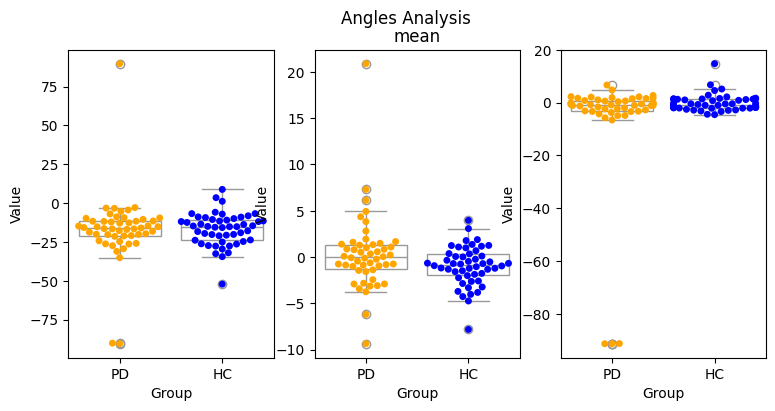

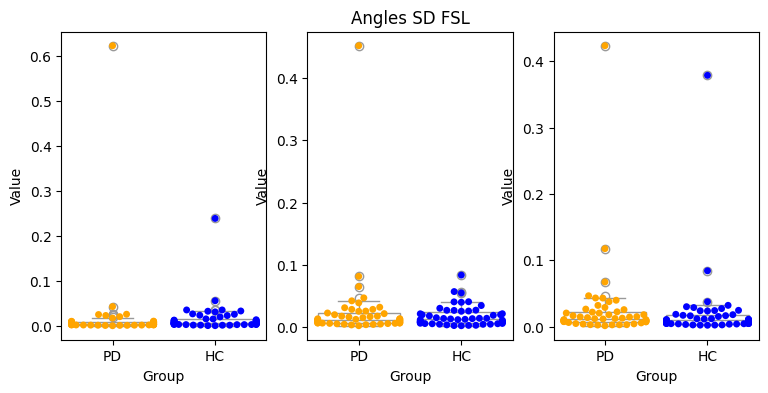

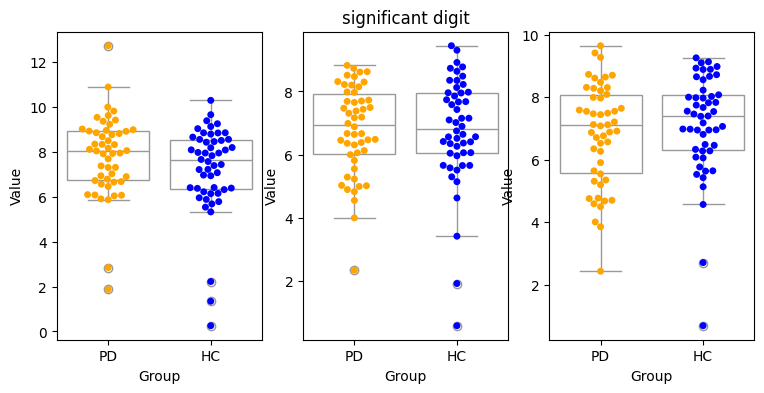

In [36]:

fig = plt.figure(figsize=(9, 4))
fig.suptitle('Angles Analysis')
plotter(np.mean(angles_mca_PD, axis=1),np.mean(angles_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(angles_mca_PD, axis=1),np.std(angles_mca_HC, axis=1), 'Angles SD FSL')


fig = plt.figure(figsize=(9, 4))
plotter(angles_significant_PD,angles_significant_HC, 'significant digit')


In [37]:
def leargest_indces(array, dict_, n=4):
    largest_idx = np.argsort(array, axis=0)[-n:]
    print(largest_idx.T)
    return np.array(list(dict_.keys()))[largest_idx.T], largest_idx.T

In [38]:
angles_mca_HC_sd = np.std(angles_mca_HC, axis=1)
shears_mca_HC_sd = np.std(shears_mca_HC, axis=1)
translations_mca_HC_sd = np.std(translations_mca_HC, axis=1)
scales_mca_HC_sd = np.std(scales_mca_HC, axis=1)

In [39]:
angles_HC_largest_sd, angles_HC_largest_sd_idx = leargest_indces(angles_mca_HC_sd,angles_mca_dict_HC)
shears_HC_largest_sd, shears_HC_largest_sd_idx = leargest_indces(shears_mca_HC_sd,shears_mca_dict_HC)
translations_HC_largest_sd, translations_HC_largest_sd_idx= leargest_indces(translations_mca_HC_sd,translation_mca_dict_HC)
scales_HC_largest_sd, scales_HC_largest_sd_idx = leargest_indces(scales_mca_HC_sd,scales_mca_dict_HC)

[[49 29 36  4]
 [ 9  6  4 36]
 [38 49 36  4]]
[[ 6 49 36  4]
 [32 48  6  4]
 [13 27 10  4]]
[[ 9 32 30  4]
 [10 13 36  4]
 [ 6 29 36  4]]
[[32 31 28 13]
 [26 16 28  4]
 [ 1 20 36  4]]


In [40]:
all_HC = np.concatenate([angles_HC_largest_sd,shears_HC_largest_sd,translations_HC_largest_sd,scales_HC_largest_sd])

In [41]:
unique_elements_HC, counts_HC = np.unique(np.ravel(all_HC), return_counts=True)

In [42]:
dict(zip(unique_elements_HC,counts_HC))

{'sub-116230': 11,
 'sub-116337': 1,
 'sub-162905': 1,
 'sub-187823': 1,
 'sub-3057': 2,
 'sub-3157': 1,
 'sub-3171': 3,
 'sub-3316': 1,
 'sub-3369': 2,
 'sub-3464': 2,
 'sub-3527': 1,
 'sub-3570': 4,
 'sub-3620': 7,
 'sub-3811': 3,
 'sub-3852': 3,
 'sub-3853': 1,
 'sub-3952': 1,
 'sub-3969': 2,
 'sub-4079': 1}

In [43]:
angles_mca_PD_sd = np.std(angles_mca_PD, axis=1)
shears_mca_PD_sd = np.std(shears_mca_PD, axis=1)
translations_mca_PD_sd = np.std(translations_mca_PD, axis=1)
scales_mca_PD_sd = np.std(scales_mca_PD, axis=1)

In [44]:
angles_PD_largest_sd, angles_PD_largest_sd_idx = leargest_indces(angles_mca_PD_sd,angles_mca_dict_PD)
shears_PD_largest_sd, shears_PD_largest_sd_idx = leargest_indces(shears_mca_PD_sd,shears_mca_dict_PD)
translations_PD_largest_sd, translations_PD_largest_sd_idx = leargest_indces(translations_mca_PD_sd,translation_mca_dict_PD)
scales_PD_largest_sd, scales_PD_largest_sd_idx = leargest_indces(scales_mca_PD_sd,scales_mca_dict_PD)

[[38 35 37  5]
 [41 48 38  5]
 [41 32 38  5]]
[[41 31 32  5]
 [43 41 38  5]
 [31 43 46  5]]
[[ 8 43 38  5]
 [31 38 48  5]
 [38 48 31  5]]
[[17 27 38  5]
 [47 27 31  5]
 [41 14 18  5]]


In [45]:
all_PD = np.concatenate([angles_PD_largest_sd,shears_PD_largest_sd,translations_PD_largest_sd,scales_PD_largest_sd])

In [46]:
unique_elements_PD, counts_PD = np.unique(np.ravel(all_PD), return_counts=True)

In [47]:
dict(zip(unique_elements_PD,counts_PD))

{'sub-106703': 1,
 'sub-120403': 1,
 'sub-121830': 8,
 'sub-3120': 1,
 'sub-3127': 1,
 'sub-3365': 1,
 'sub-3403': 12,
 'sub-3505': 2,
 'sub-3700': 3,
 'sub-3709': 5,
 'sub-3777': 3,
 'sub-3823': 1,
 'sub-3960': 1,
 'sub-3970': 5,
 'sub-4121': 1,
 'sub-54144': 2}

In [48]:
#some thing like correlation but for catgorical variables

In [49]:
groups = ['angles', 'shears', 'translations', 'scales']
all_ravel_HC = [np.ravel(angles_HC_largest_sd),np.ravel(shears_HC_largest_sd),np.ravel(translations_HC_largest_sd),np.ravel(scales_HC_largest_sd)]
all_ravel_PD = [np.ravel(angles_PD_largest_sd),np.ravel(shears_PD_largest_sd),np.ravel(translations_PD_largest_sd),np.ravel(scales_PD_largest_sd)]

In [50]:
metrics_utils.print_metrics(groups, all_ravel_HC)

angles vs shears
cosine similarity: 0.701646
jaccard similarity: 0.333333
*********

angles vs translations
cosine similarity: 0.789352
jaccard similarity: 0.454545
*********

angles vs scales
cosine similarity: 0.441261
jaccard similarity: 0.133333
*********

shears vs translations
cosine similarity: 0.800000
jaccard similarity: 0.500000
*********

shears vs scales
cosine similarity: 0.503115
jaccard similarity: 0.266667
*********

translations vs scales
cosine similarity: 0.559017
jaccard similarity: 0.266667
*********



In [51]:
metrics_utils.print_metrics(groups, all_ravel_PD)

angles vs shears
cosine similarity: 0.680545
jaccard similarity: 0.400000
*********

angles vs translations
cosine similarity: 0.741249
jaccard similarity: 0.300000
*********

angles vs scales
cosine similarity: 0.613941
jaccard similarity: 0.230769
*********

shears vs translations
cosine similarity: 0.694365
jaccard similarity: 0.444444
*********

shears vs scales
cosine similarity: 0.639010
jaccard similarity: 0.333333
*********

translations vs scales
cosine similarity: 0.591608
jaccard similarity: 0.250000
*********



In [52]:
angles_mca_HC_mean = np.mean(angles_mca_HC, axis=1)
shears_mca_HC_mean = np.mean(shears_mca_HC, axis=1)
translations_mca_HC_mean = np.mean(translations_mca_HC, axis=1)
scales_mca_HC_mean = np.mean(scales_mca_HC, axis=1)

In [53]:
#look to how vectorize it maybe
result_HC = np.zeros((n_hc_fsl,10))
for i in range(n_hc_fsl):
    for j in range(10):
        result_HC[i,j] = metrics_utils.framewise_displacement(translations_mca_HC[i,j], angles_mca_HC[i,j], translations_ieee_HC[i], np.degrees(angles_ieee_HC[i]))

In [54]:
result_PD = np.zeros((n_pd_fsl,10))
for i in range(n_pd_fsl):
    for j in range(10):
        result_PD[i,j] = metrics_utils.framewise_displacement(translations_mca_PD[i,j], angles_mca_PD[i,j], translations_ieee_PD[i], np.degrees(angles_ieee_PD[i]))

In [55]:
fd_mean_HC = np.mean(result_HC, axis=1)
fd_sd_HC = np.std(result_HC, axis=1)

In [56]:
fd_mean_PD = np.mean(result_PD, axis=1)
fd_sd_PD = np.std(result_PD, axis=1)

In [57]:
fd_significant_digits_PD = np.array([sd.significant_digits(result_PD[i], reference=fd_mean_PD[i], basis=10) for i in range(n_pd_fsl)])

In [58]:
fd_significant_digits_HC = np.array([sd.significant_digits(result_HC[i], reference=fd_mean_HC[i], basis=10) for i in range(n_pd_fsl)])

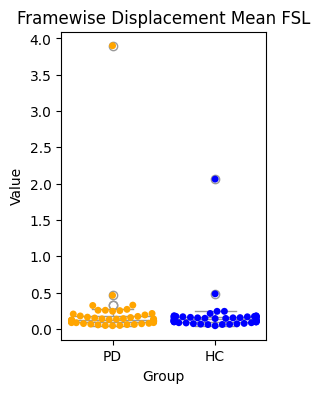

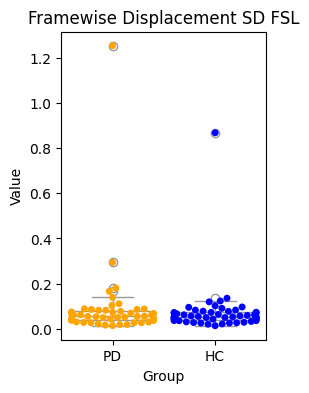

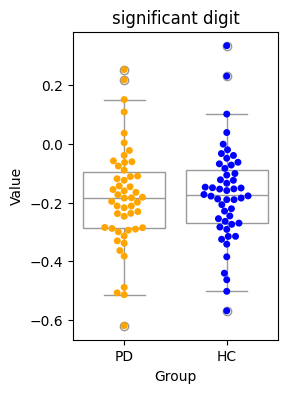

In [59]:
fig = plt.figure(figsize=(9, 4))
# fig.suptitle('Framewise Displacement')
plotter(fd_mean_PD.reshape(-1,1),fd_mean_HC.reshape(-1,1), 'Framewise Displacement Mean FSL')

fig = plt.figure(figsize=(9, 4))
plotter(fd_sd_PD.reshape(-1,1),fd_sd_HC.reshape(-1,1), 'Framewise Displacement SD FSL')


fig = plt.figure(figsize=(9, 4))
plotter(fd_significant_digits_PD.reshape(-1,1),fd_significant_digits_HC.reshape(-1,1), 'significant digit')


In [60]:
ants_path_HC = Path("./pipline/hc/outputs/ants/anat-12dofs")
ants_path_PD = Path("./pipline/pd/outputs/ants/anat-12dofs")

In [61]:
ants_paths_HC = load_utils.get_paths(ants_path_HC, Path("./HC_selected_subjects.txt"),  pattern="_ses-BL0GenericAffine")
ants_paths_PD = load_utils.get_paths(ants_path_PD, Path("./PD_selected_subjects.txt"),  pattern="_ses-BL0GenericAffine")

In [62]:
import importlib
importlib.reload(load_utils)

<module 'load_utils' from '/lustre06/project/6061841/niusham/mca_linear_registration/load_utils.py'>

In [63]:
ants_mat_dic_HC, ants_error_HC = load_utils.get_matrices(ants_paths_HC)
ants_mat_dic_HC = {key.replace('GenericAffine', ''): value for key, value in ants_mat_dic_HC.items()}

ants_mat_dic_PD, ants_error_PD = load_utils.get_matrices(ants_paths_PD)
ants_mat_dic_PD = {key.replace('GenericAffine', ''): value for key, value in ants_mat_dic_PD.items()}

In [64]:
ants_error_PD, ants_error_HC

([], [])

In [65]:
# for sub in all_failed_hc_subs:
#     del ants_mat_dic_HC[sub]

# for sub in all_failed_pd_subs:    
#     del ants_mat_dic_PD[sub]

In [66]:
# #removing failed subject from ants 
# ants_failed_hc_subs = ["sub-116230", "sub-3620"]
# ants_failed_pd_subs = ["sub-3365"]

# for sub in ants_failed_hc_subs:
#     del ants_mat_dic_HC[sub]

# for sub in ants_failed_pd_subs:
#     del ants_mat_dic_PD[sub]

n_pd_ants = len(ants_mat_dic_PD.keys())
n_hc_ants = len(ants_mat_dic_HC.keys())

In [67]:
ants_scales_ieee_PD, ants_translations_ieee_PD, ants_angles_ieee_PD, ants_shears_ieee_PD = transformation_arrays_ieee(ants_mat_dic_PD)
ants_scales_ieee_HC, ants_translations_ieee_HC, ants_angles_ieee_HC, ants_shears_ieee_HC = transformation_arrays_ieee(ants_mat_dic_HC)

ants_scales_mca_dict_PD, ants_translation_mca_dict_PD, ants_angles_mca_dict_PD, ants_shears_mca_dict_PD = transformation_dictionaries_mca(ants_mat_dic_PD)
ants_scales_mca_dict_HC, ants_translation_mca_dict_HC, ants_angles_mca_dict_HC, ants_shears_mca_dict_HC = transformation_dictionaries_mca(ants_mat_dic_HC)

In [68]:
ants_scales_mca_PD = np.stack([value for value in ants_scales_mca_dict_PD.values()])
ants_scales_mca_HC = np.stack([value for value in ants_scales_mca_dict_HC.values()])

ants_scales_significant_PD = np.stack([sd.significant_digits(ants_scales_mca_PD[i,:,:], reference=np.mean(ants_scales_mca_PD[i,:,:]), axis=0) for i in range(n_pd_ants)])
ants_scales_significant_HC = np.stack([sd.significant_digits(ants_scales_mca_HC[i,:,:], reference=np.mean(ants_scales_mca_HC[i,:,:]), axis=0) for i in range(n_hc_ants)])

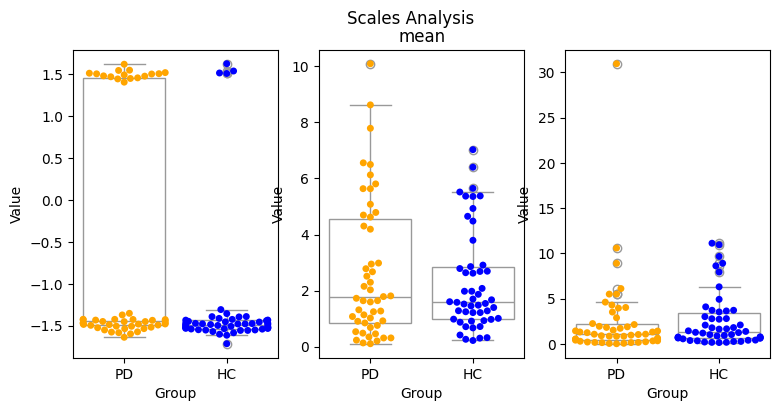

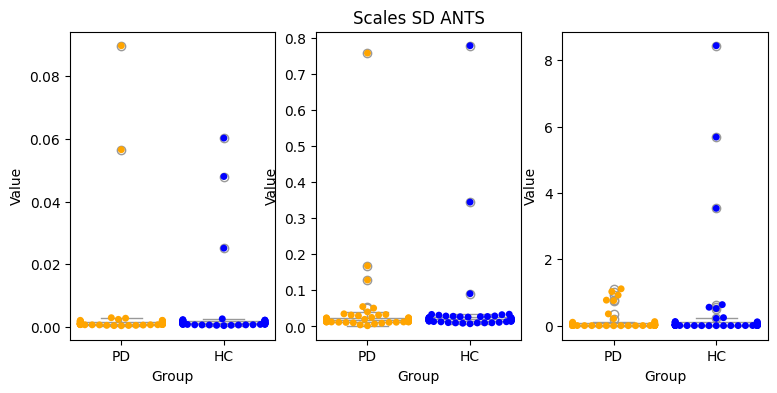

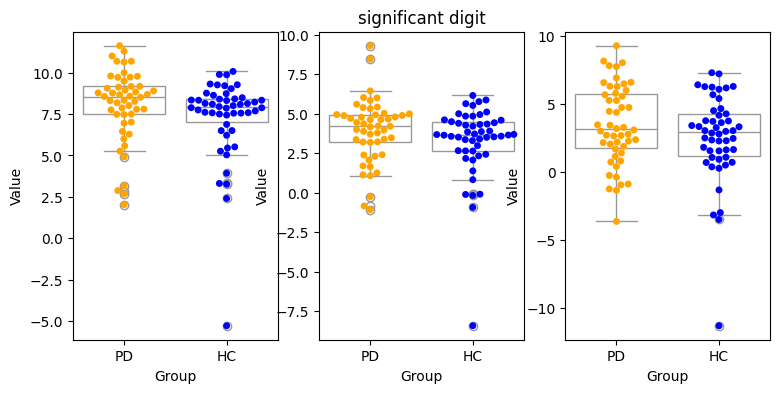

In [69]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle('Scales Analysis')
plotter(np.mean(ants_scales_mca_PD, axis=1),np.mean(ants_scales_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(ants_scales_mca_PD, axis=1),np.std(ants_scales_mca_HC, axis=1), 'Scales SD ANTS')


fig = plt.figure(figsize=(9, 4))
plotter(ants_scales_significant_PD,ants_scales_significant_HC, 'significant digit')



In [70]:
ants_translations_mca_PD = np.stack([value for value in ants_translation_mca_dict_PD.values()])
ants_translations_mca_HC = np.stack([value for value in ants_translation_mca_dict_HC.values()])

ants_translations_significant_PD = np.stack([sd.significant_digits(ants_translations_mca_PD[i,:,:], reference=np.mean(ants_translations_mca_PD[i,:,:]), axis=0) for i in range(n_pd_ants)])
ants_translations_significant_HC = np.stack([sd.significant_digits(ants_translations_mca_HC[i,:,:], reference=np.mean(ants_translations_mca_HC[i,:,:]), axis=0) for i in range(n_hc_ants)])

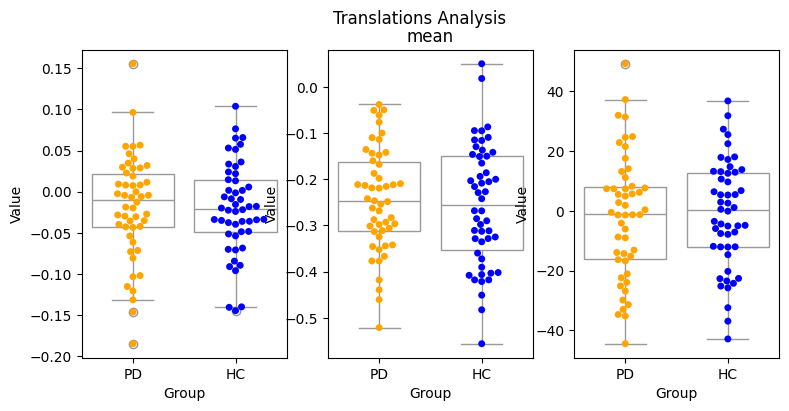

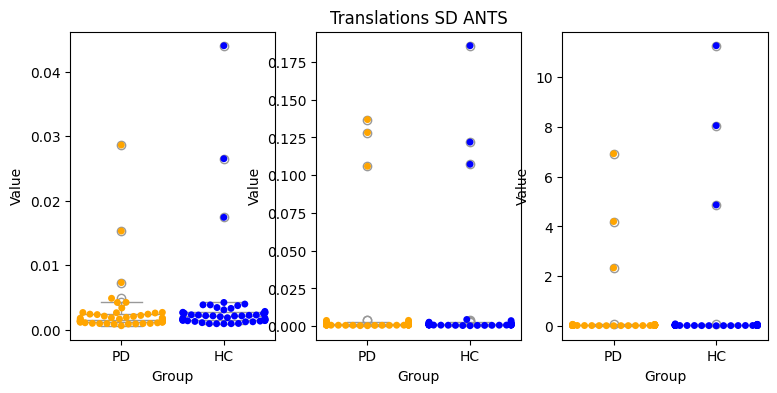

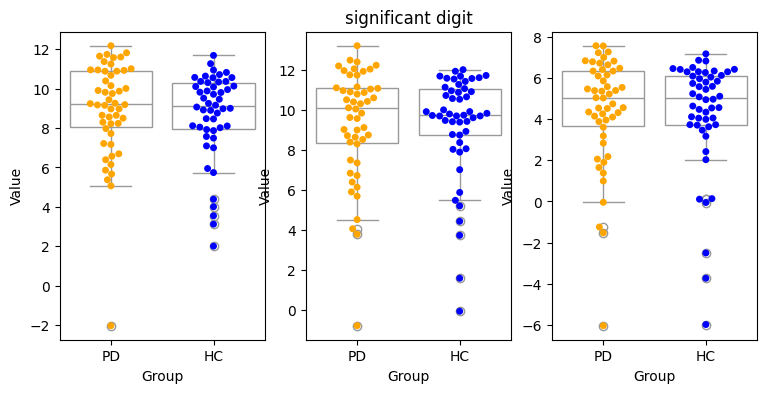

In [71]:
fig = plt.figure(figsize=(9, 4))
fig.suptitle('Translations Analysis')
plotter(np.mean(ants_translations_mca_PD, axis=1),np.mean(ants_translations_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(ants_translations_mca_PD, axis=1),np.std(ants_translations_mca_HC, axis=1), 'Translations SD ANTS')


fig = plt.figure(figsize=(9, 4))
plotter(ants_translations_significant_PD,ants_translations_significant_HC, 'significant digit')



In [72]:
ants_shears_mca_PD = np.stack([value for value in ants_shears_mca_dict_PD.values()])
ants_shears_mca_HC = np.stack([value for value in ants_shears_mca_dict_HC.values()])
ants_shears_significant_PD = np.stack([sd.significant_digits(ants_shears_mca_PD[i,:,:], reference=np.mean(ants_shears_mca_PD[i,:,:]), axis=0) for i in range(n_pd_ants)])
ants_shears_significant_HC = np.stack([sd.significant_digits(ants_shears_mca_HC[i,:,:], reference=np.mean(ants_shears_mca_HC[i,:,:]), axis=0) for i in range(n_hc_ants)])

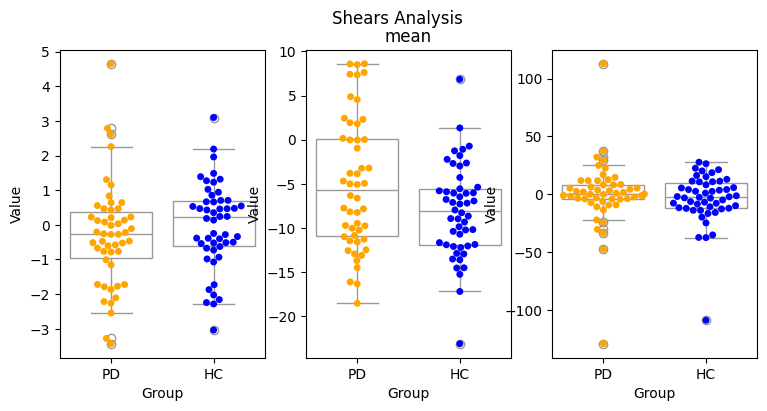

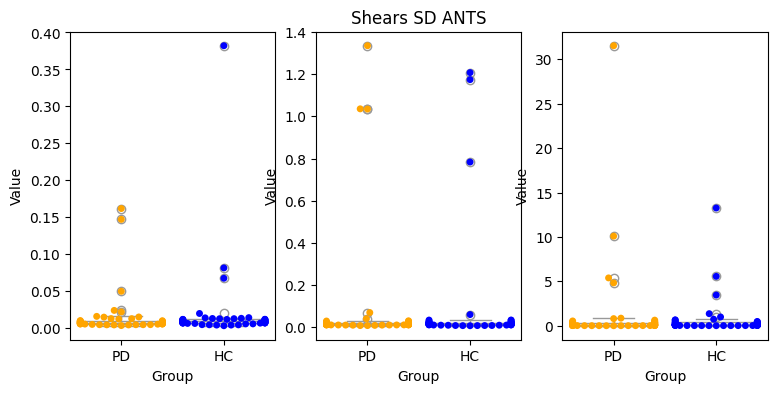

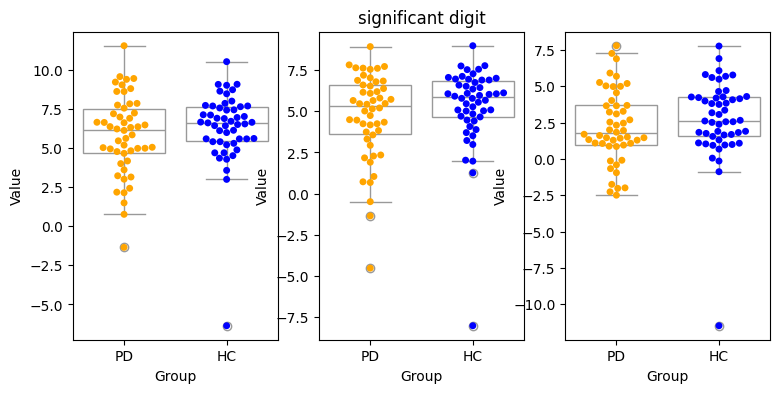

In [73]:

fig = plt.figure(figsize=(9, 4))
fig.suptitle('Shears Analysis')
plotter(np.mean(ants_shears_mca_PD, axis=1),np.mean(ants_shears_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(ants_shears_mca_PD, axis=1),np.std(ants_shears_mca_HC, axis=1), 'Shears SD ANTS')


fig = plt.figure(figsize=(9, 4))
plotter(ants_shears_significant_PD,ants_shears_significant_HC, 'significant digit')


In [74]:
ants_angles_mca_PD = np.degrees(np.stack([value for value in ants_angles_mca_dict_PD.values()]))
ants_angles_mca_HC = np.degrees(np.stack([value for value in ants_angles_mca_dict_HC.values()]))

ants_angles_significant_PD = np.stack([sd.significant_digits(ants_angles_mca_PD[i,:,:], reference=np.mean(ants_angles_mca_PD[i,:,:]), axis=0) for i in range(n_pd_ants)])
ants_angles_significant_HC = np.stack([sd.significant_digits(ants_angles_mca_HC[i,:,:], reference=np.mean(ants_angles_mca_HC[i,:,:]), axis=0) for i in range(n_hc_ants)])

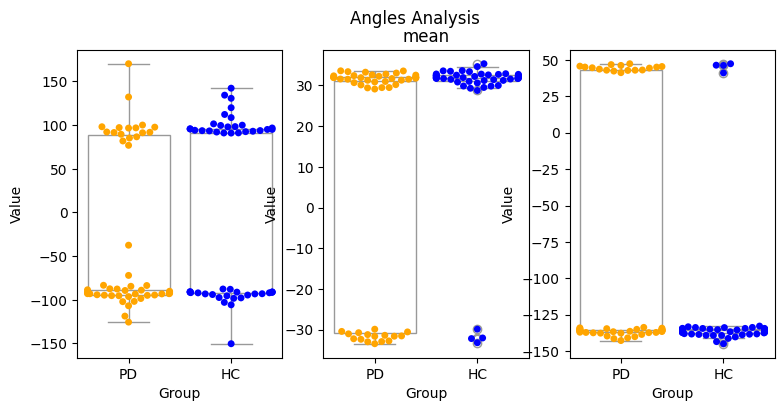

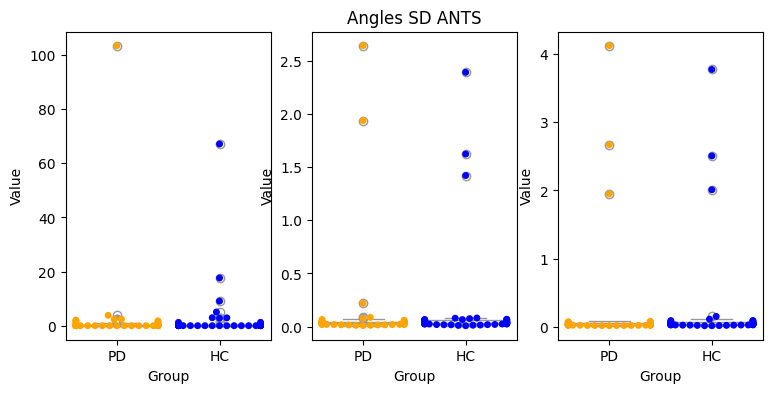

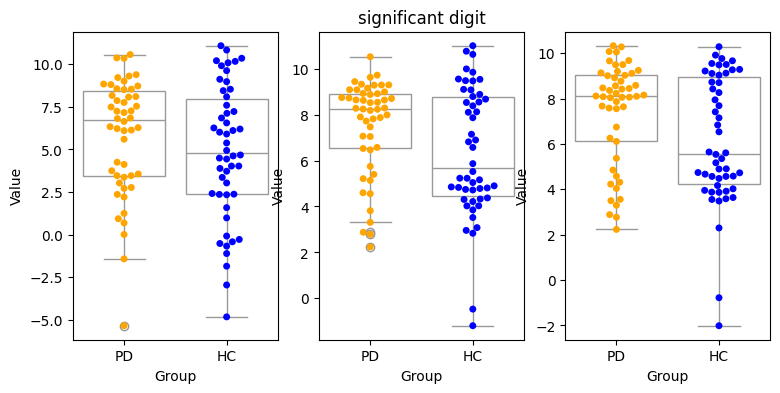

In [75]:

fig = plt.figure(figsize=(9, 4))
fig.suptitle('Angles Analysis')
plotter(np.mean(ants_angles_mca_PD, axis=1),np.mean(ants_angles_mca_HC, axis=1), 'mean')

fig = plt.figure(figsize=(9, 4))
plotter(np.std(ants_angles_mca_PD, axis=1),np.std(ants_angles_mca_HC, axis=1), 'Angles SD ANTS')


fig = plt.figure(figsize=(9, 4))
plotter(ants_angles_significant_PD,ants_angles_significant_HC, 'significant digit')


In [76]:
ants_angles_mca_HC_sd = np.std(ants_angles_mca_HC, axis=1)
ants_shears_mca_HC_sd = np.std(ants_shears_mca_HC, axis=1)
ants_translations_mca_HC_sd = np.std(ants_translations_mca_HC, axis=1)
ants_scales_mca_HC_sd = np.std(ants_scales_mca_HC, axis=1)

ants_angles_HC_largest_sd, ants_angles_HC_largest_sd_idx = leargest_indces(ants_angles_mca_HC_sd,ants_angles_mca_dict_HC)
ants_shears_HC_largest_sd, ants_shears_HC_largest_sd_idx = leargest_indces(ants_shears_mca_HC_sd,ants_shears_mca_dict_HC)
ants_translations_HC_largest_sd, ants_translations_HC_largest_sd_idx = leargest_indces(ants_translations_mca_HC_sd,ants_translation_mca_dict_HC)
ants_scales_HC_largest_sd, ants_scales_HC_largest_sd_idx = leargest_indces(ants_scales_mca_HC_sd,ants_scales_mca_dict_HC)

[[35  4 10 36]
 [37 10  4 36]
 [41  4 10 36]]
[[ 3 10  4 36]
 [31  4 10 36]
 [10  4 23 36]]
[[31 10  4 36]
 [31  4 10 36]
 [16 10  4 36]]
[[48 10 36  4]
 [38 10  4 36]
 [23  4 36 10]]


In [77]:
ants_all_HC = np.concatenate([ants_angles_HC_largest_sd,ants_shears_HC_largest_sd,ants_translations_HC_largest_sd,ants_scales_HC_largest_sd])
ants_unique_elements_HC, ants_counts_HC = np.unique(np.ravel(ants_all_HC), return_counts=True)
dict(zip(ants_unique_elements_HC,ants_counts_HC))

{'sub-116230': 12,
 'sub-3157': 1,
 'sub-3316': 1,
 'sub-3370': 2,
 'sub-3389': 1,
 'sub-3414': 1,
 'sub-3620': 12,
 'sub-3765': 1,
 'sub-3952': 3,
 'sub-3969': 12,
 'sub-4067': 1,
 'sub-4079': 1}

In [78]:
ants_angles_mca_PD_sd = np.std(ants_angles_mca_PD, axis=1)
ants_shears_mca_PD_sd = np.std(ants_shears_mca_PD, axis=1)
ants_translations_mca_PD_sd = np.std(ants_translations_mca_PD, axis=1)
ants_scales_mca_PD_sd = np.std(ants_scales_mca_PD, axis=1)

ants_angles_PD_largest_sd, ants_angles_PD_largest_sd_idx = leargest_indces(ants_angles_mca_PD_sd,ants_angles_mca_dict_PD)
ants_shears_PD_largest_sd, ants_shears_PD_largest_sd_idx = leargest_indces(ants_shears_mca_PD_sd,ants_shears_mca_dict_PD)
ants_translations_PD_largest_sd, ants_translations_PD_largest_sd_idx = leargest_indces(ants_translations_mca_PD_sd,ants_translation_mca_dict_PD)
ants_scales_PD_largest_sd, ants_scales_PD_largest_sd_idx = leargest_indces(ants_scales_mca_PD_sd,ants_scales_mca_dict_PD)

[[18 12 35  3]
 [17 18 11 15]
 [24 11 15 18]]
[[43 18 11 15]
 [17 18 15 11]
 [17 35  5  3]]
[[ 5 15 11 18]
 [ 5 18 15 11]
 [24 11 18 15]]
[[24 15 18 11]
 [43 18 11 15]
 [17 11  3  5]]


In [79]:
ants_all_PD = np.concatenate([ants_angles_PD_largest_sd,ants_shears_PD_largest_sd,ants_translations_PD_largest_sd,ants_scales_PD_largest_sd])
ants_unique_elements_PD, ants_counts_PD = np.unique(np.ravel(ants_all_PD), return_counts=True)
dict(zip(ants_unique_elements_PD,ants_counts_PD))

{'sub-120403': 2,
 'sub-171635': 1,
 'sub-3001': 3,
 'sub-3176': 3,
 'sub-3365': 10,
 'sub-3403': 4,
 'sub-3586': 10,
 'sub-3777': 2,
 'sub-3960': 4,
 'sub-42264': 9}

In [80]:
groups = ['angles', 'shears', 'translations', 'scales']
ants_all_ravel_HC = [np.ravel(ants_angles_HC_largest_sd),np.ravel(ants_shears_HC_largest_sd),np.ravel(ants_translations_HC_largest_sd),np.ravel(ants_scales_HC_largest_sd)]
ants_all_ravel_PD = [np.ravel(ants_angles_PD_largest_sd),np.ravel(ants_shears_PD_largest_sd),np.ravel(ants_translations_PD_largest_sd),np.ravel(ants_scales_PD_largest_sd)]

In [81]:
metrics_utils.print_metrics(groups, ants_all_ravel_HC)

angles vs shears
cosine similarity: 0.900000
jaccard similarity: 0.333333
*********

angles vs translations
cosine similarity: 0.871421
jaccard similarity: 0.375000
*********

angles vs scales
cosine similarity: 0.900000
jaccard similarity: 0.333333
*********

shears vs translations
cosine similarity: 0.935971
jaccard similarity: 0.571429
*********

shears vs scales
cosine similarity: 0.933333
jaccard similarity: 0.500000
*********

translations vs scales
cosine similarity: 0.871421
jaccard similarity: 0.375000
*********



In [82]:
metrics_utils.print_metrics(groups, ants_all_ravel_PD)

angles vs shears
cosine similarity: 0.858116
jaccard similarity: 0.600000
*********

angles vs translations
cosine similarity: 0.829156
jaccard similarity: 0.444444
*********

angles vs scales
cosine similarity: 0.863636
jaccard similarity: 0.600000
*********

shears vs translations
cosine similarity: 0.790569
jaccard similarity: 0.444444
*********

shears vs scales
cosine similarity: 0.905789
jaccard similarity: 0.777778
*********

translations vs scales
cosine similarity: 0.904534
jaccard similarity: 0.625000
*********



In [83]:
#look to how vectorize it maybe
ants_result_HC = np.zeros((n_hc_ants,10))
for i in range(n_hc_ants):
    for j in range(10):
        ants_result_HC[i,j] = metrics_utils.framewise_displacement(ants_translations_mca_HC[i,j], ants_angles_mca_HC[i,j], ants_translations_ieee_HC[i], np.degrees(ants_angles_ieee_HC[i]))
ants_result_PD = np.zeros((n_pd_ants,10))
for i in range(n_pd_ants):
    for j in range(10):
        ants_result_PD[i,j] = metrics_utils.framewise_displacement(ants_translations_mca_PD[i,j], ants_angles_mca_PD[i,j], ants_translations_ieee_PD[i], np.degrees(ants_angles_ieee_PD[i]))

In [84]:
ants_fd_mean_HC = np.mean(ants_result_HC, axis=1)
ants_fd_sd_HC = np.std(ants_result_HC, axis=1)

ants_fd_mean_PD = np.mean(ants_result_PD, axis=1)
ants_fd_sd_PD = np.std(ants_result_PD, axis=1)

ants_fd_significant_digits_PD = np.array([sd.significant_digits(ants_result_PD[i], reference=ants_fd_mean_PD[i], basis=10) for i in range(n_pd_ants)])
ants_fd_significant_digits_HC = np.array([sd.significant_digits(ants_result_HC[i], reference=ants_fd_mean_HC[i], basis=10) for i in range(n_hc_ants)])

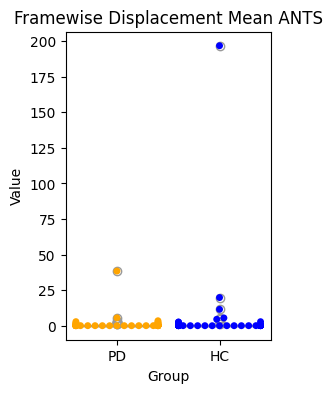

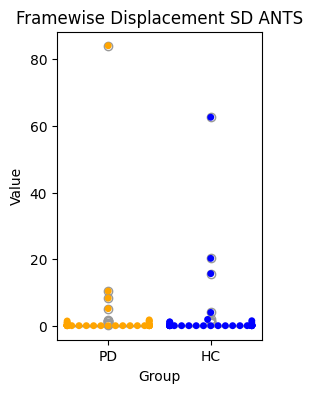

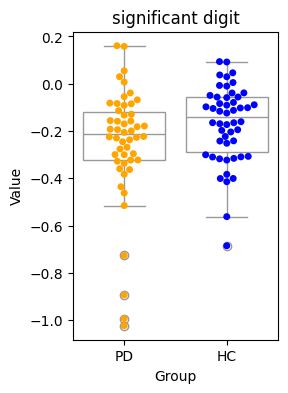

In [85]:
fig = plt.figure(figsize=(9, 4))
plotter(ants_fd_mean_PD.reshape(-1,1),ants_fd_mean_HC.reshape(-1,1), 'Framewise Displacement Mean ANTS')

fig = plt.figure(figsize=(9, 4))
plotter(ants_fd_sd_PD.reshape(-1,1),ants_fd_sd_HC.reshape(-1,1), 'Framewise Displacement SD ANTS')


fig = plt.figure(figsize=(9, 4))
plotter(ants_fd_significant_digits_PD.reshape(-1,1),ants_fd_significant_digits_HC.reshape(-1,1), 'significant digit')


In [86]:
a = np.array(list(mat_dic_PD.keys()))
a[np.where(fd_mean_PD >= 1)]

array(['sub-3403'], dtype='<U10')

In [87]:
a = np.array(list(ants_mat_dic_PD.keys()))
a[np.where(ants_fd_mean_PD >= 1)]

array(['sub-3001', 'sub-3403', 'sub-3586', 'sub-171635', 'sub-42264',
       'sub-3960', 'sub-3365', 'sub-3709', 'sub-120403', 'sub-70818'],
      dtype='<U10')

In [88]:
a = np.array(list(mat_dic_HC.keys()))
a[np.where(fd_mean_HC >= 1)]

array(['sub-116230'], dtype='<U10')

In [89]:
ants_fd_mean_PD[np.where(ants_fd_mean_PD >= 1)]

array([38.41983189,  2.56652252,  1.86422177,  1.70312065,  3.52181834,
        1.35875203,  5.55482974,  1.62033397,  2.89587255,  1.54777765])

In [90]:
a = np.array(list(ants_mat_dic_HC.keys()))
a[np.where(ants_fd_mean_HC >= 1)]

array(['sub-3807', 'sub-116230', 'sub-3969', 'sub-3106', 'sub-3370',
       'sub-4067', 'sub-3620', 'sub-3389', 'sub-3157'], dtype='<U10')

In [102]:
for i in (np.where(ants_fd_mean_HC >= 1))[0].tolist():
    print(a[i], ants_fd_mean_HC[i])
# ants_fd_mean_HC[np.where(ants_fd_mean_HC >= 1)]

sub-3807 2.550010035849657
sub-116230 11.547495896353496
sub-3969 19.829796504007057
sub-3106 4.5552632035682645
sub-3370 1.1118476179162577
sub-4067 5.501897110849399
sub-3620 196.69655630875323
sub-3389 2.6292510515046104
sub-3157 2.8769890181780653


In [104]:
a = np.array(list(ants_mat_dic_PD.keys()))

In [105]:
for i in (np.where(ants_fd_mean_PD >= 1))[0].tolist():
    print(a[i], ants_fd_mean_PD[i])

sub-3001 38.419831891337886
sub-3403 2.5665225176675532
sub-3586 1.8642217658781608
sub-171635 1.7031206454590033
sub-42264 3.5218183434334733
sub-3960 1.3587520305442995
sub-3365 5.554829739135317
sub-3709 1.6203339708300426
sub-120403 2.895872547065295
sub-70818 1.5477776464295872


In [108]:
a = np.array(list(mat_dic_PD.keys()))
for i in (np.where(fd_mean_PD >= 0.2))[0].tolist():
    print(a[i], fd_mean_PD[i])

sub-3403 3.900103655514654
sub-171635 0.2428324725057776
sub-3960 0.2693688738969998
sub-3150 0.2049763724842481
sub-3709 0.4618256901903436
sub-54144 0.25654383502109235
sub-126812 0.2125688321558769
sub-121830 0.3225434714227679
sub-3970 0.25686892278655477
sub-3777 0.25162891458214603
sub-3700 0.3273075258324423


In [109]:
a = np.array(list(mat_dic_HC.keys()))
for i in (np.where(fd_mean_HC >= 0.2))[0].tolist():
    print(a[i], fd_mean_HC[i])

sub-116230 2.0628353549840517
sub-3969 0.24207252985161318
sub-156484 0.24204787040369807
sub-3369 0.21211396184417675
sub-3620 0.48308328222300034


In [92]:
fd_mean_PD

array([0.12133538, 0.12064156, 0.04388195, 0.0658499 , 0.12860323,
       3.90010366, 0.1782344 , 0.13843488, 0.14167542, 0.15674081,
       0.08603714, 0.0708466 , 0.24283247, 0.11398749, 0.11028146,
       0.12151529, 0.05493   , 0.26936887, 0.14992876, 0.10070606,
       0.10586051, 0.20497637, 0.04724268, 0.07683626, 0.17217906,
       0.08625413, 0.09868095, 0.10838226, 0.09825104, 0.13889526,
       0.08506516, 0.46182569, 0.25654384, 0.21256883, 0.0591314 ,
       0.1189134 , 0.13456966, 0.19240706, 0.32254347, 0.06122636,
       0.10331792, 0.25686892, 0.1030391 , 0.25162891, 0.09816258,
       0.04633957, 0.11485024, 0.16170932, 0.32730753, 0.07360178])

In [93]:
fd_mean_HC

array([0.15199039, 0.12087844, 0.10152055, 0.10173383, 2.06283535,
       0.10511497, 0.17569103, 0.17270986, 0.07563333, 0.15919476,
       0.24207253, 0.09647928, 0.06321326, 0.14234172, 0.15220361,
       0.06082794, 0.12253022, 0.24204787, 0.04367478, 0.11897171,
       0.15519295, 0.05955098, 0.1664774 , 0.09516948, 0.16093801,
       0.0658972 , 0.18073201, 0.12644542, 0.09918409, 0.21211396,
       0.15727558, 0.17184983, 0.14634993, 0.06988442, 0.0974561 ,
       0.11746941, 0.48308328, 0.10589505, 0.17395992, 0.14730457,
       0.17094418, 0.11925361, 0.07206623, 0.08520413, 0.08494635,
       0.08182054, 0.14427337, 0.16724466, 0.17966268, 0.16030287])

In [94]:
#ttest comparing pd to hc after removing failed subjects (FD)

# ttest between diffrernt subject removing all the failed from both

In [ ]:
# from scipy import stats

# ants_t_stat, ants_p_value = stats.ttest_ind(ants_fd_mean_PD, ants_fd_mean_HC, equal_var=False)
# fsl_t_stat, fsl_p_value = stats.ttest_ind(fd_mean_PD, fd_mean_HC, equal_var=False)

: 

In [ ]:
# ants_p_value, fsl_p_value

: 

: 

In [ ]:
a = np.concatenate([ants_fd_mean_PD,ants_fd_mean_HC])
b = np.concatenate([fd_mean_PD,fd_mean_HC])
t_stat, p_value = stats.ttest_rel(a, b)

: 

In [ ]:
len(b)

: 

In [ ]:
np.mean(a)

: 

In [ ]:
np.median(a)

: 

In [ ]:
np.mean(b)

: 

In [ ]:
np.median(b)

: 

In [ ]:
from matplotlib.pyplot import hist
hist(a, alpha=0.3)
plt.show()
hist(b, alpha=0.3)
plt.show()


: 

In [ ]:
a

: 

In [ ]:
p_value

: 

In [ ]:
t_stat, p_value = stats.ttest_rel(ants_fd_mean_PD, fd_mean_PD)


: 

In [ ]:
p_value

: 

In [ ]:
p_valuet_stat, p_value = stats.ttest_rel(ants_fd_mean_HC, fd_mean_HC)

: 

In [ ]:
p_value

: 